In [1]:
%pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import yaml
import kagglehub
import shutil
import pandas as pd

In [3]:
data = {
    "path": "D:/Dateien/Github_FabianDubach/cvai-classisign/dataset",
    "train": "images/train",
    "val": "images/val",
    "nc": 1,
    "names": [
        'sign detected'
        ]
}

with open("data.yaml", "w") as file:
    yaml.dump(data, file, sort_keys=False)

In [4]:
# Download dataset
download_path = kagglehub.dataset_download("safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb")

# Paths
train_image_dir = os.path.join(download_path, "TrainIJCNN2013", "TrainIJCNN2013")
test_image_dir = os.path.join(download_path, "TestIJCNN2013", "TestIJCNN2013Download")
annotation_file = os.path.join(download_path, "gt.txt")
output_train_image_dir = "dataset/images/train"
output_test_image_dir = "dataset/images/test"
output_label_dir = "dataset/labels/train"
val_image_dir = "dataset/images/val"
val_label_dir = "dataset/labels/val"

# Create directories
os.makedirs(output_train_image_dir, exist_ok=True)
os.makedirs(output_test_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# Read annotations
with open(annotation_file, "r") as f:
    lines = f.readlines()

# Parse and convert each line
for line in lines:
    parts = line.strip().split(";")
    img_name, x1, y1, x2, y2, _ = parts  # Ignore class_id
    x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))

    img_path = os.path.join(train_image_dir, img_name)
    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue
    h, w = img.shape[:2]

    # YOLO format
    x_center = ((x1 + x2) / 2) / w
    y_center = ((y1 + y2) / 2) / h
    width = (x2 - x1) / w
    height = (y2 - y1) / h

    # Change extension to .jpg
    new_img_name = img_name.replace(".ppm", ".jpg")
    label_name = new_img_name.replace(".jpg", ".txt")

    label_path = os.path.join(output_label_dir, label_name)
    with open(label_path, "a") as label_file:
        label_file.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    out_img_path = os.path.join(output_train_image_dir, new_img_name)
    if not os.path.exists(out_img_path):
        cv2.imwrite(out_img_path, img)

# Move the last 60 label-image pairs to validation set
label_files = sorted([f for f in os.listdir(output_label_dir) if f.endswith(".txt")])
val_sample = label_files[-60:]

for label_file in val_sample:
    shutil.move(os.path.join(output_label_dir, label_file), os.path.join(val_label_dir, label_file))
    image_file = label_file.replace(".txt", ".jpg")
    src_img = os.path.join(output_train_image_dir, image_file)
    dst_img = os.path.join(val_image_dir, image_file)
    if os.path.exists(src_img):
        shutil.move(src_img, dst_img)

# Copy and convert test images to JPG
for img_name in os.listdir(test_image_dir):
    if img_name.endswith(".ppm"):
        img_path = os.path.join(test_image_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            new_img_name = img_name.replace(".ppm", ".jpg")
            out_img_path = os.path.join(output_test_image_dir, new_img_name)
            cv2.imwrite(out_img_path, img)

In [5]:
!yolo detect train data=data.yaml model=yolov8n.pt epochs=30 imgsz=640

New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.139  Python-3.12.8 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=Fa


train: Scanning D:\Dateien\Github_FabianDubach\cvai-classisign\dataset\labels\train...:   0%|          | 0/446 [00:00<?, ?it/s]
train: Scanning D:\Dateien\Github_FabianDubach\cvai-classisign\dataset\labels\train... 65 images, 0 backgrounds, 0 corrupt:  15%|█▍        | 65/446 [00:00<00:00, 643.82it/s]
train: Scanning D:\Dateien\Github_FabianDubach\cvai-classisign\dataset\labels\train... 130 images, 0 backgrounds, 0 corrupt:  29%|██▉       | 130/446 [00:00<00:00, 603.32it/s]
train: Scanning D:\Dateien\Github_FabianDubach\cvai-classisign\dataset\labels\train... 191 images, 0 backgrounds, 0 corrupt:  43%|████▎     | 191/446 [00:00<00:00, 603.89it/s]
train: Scanning D:\Dateien\Github_FabianDubach\cvai-classisign\dataset\labels\train... 263 images, 0 backgrounds, 0 corrupt:  59%|█████▉    | 263/446 [00:00<00:00, 646.36it/s]
train: Scanning D:\Dateien\Github_FabianDubach\cvai-classisign\dataset\labels\train... 339 images, 0 backgrounds, 0 corrupt:  76%|███████▌  | 339/446 [00:00<00:00, 678.2

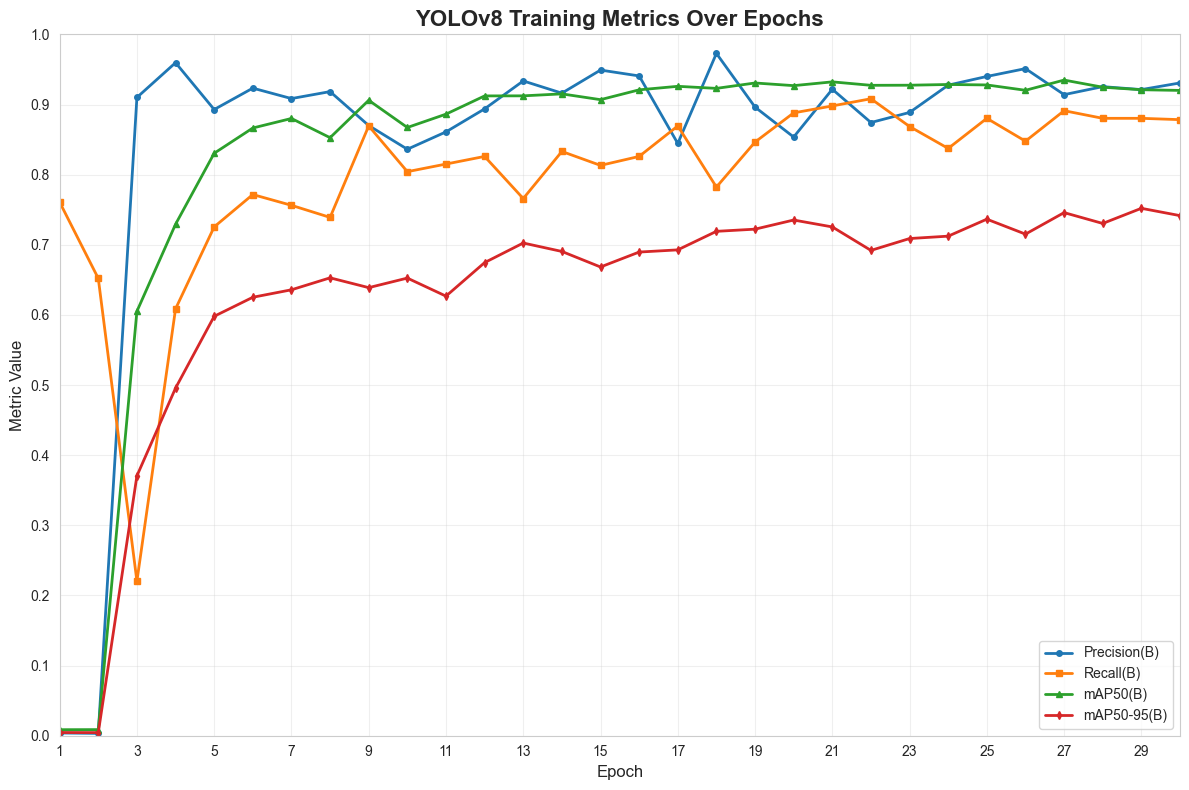

Epoch-wise performance metrics:
 epoch  metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  metrics/mAP50-95(B)
     1               0.00389            0.76087           0.00859              0.00453
     2               0.00333            0.65217           0.00871              0.00446
     3               0.91018            0.22038           0.60525              0.37057
     4               0.95975            0.60870           0.72938              0.49571
     5               0.89298            0.72561           0.83060              0.59811
     6               0.92348            0.77174           0.86663              0.62525
     7               0.90860            0.75638           0.88022              0.63591
     8               0.91853            0.73913           0.85282              0.65296
     9               0.87015            0.86957           0.90616              0.63898
    10               0.83633            0.80435           0.86735              0.65260
    11     

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the results CSV file
df = pd.read_csv("runs/detect/train/results.csv")

# Ensure we have data for all 30 epochs
df_epochs = df[df['epoch'] <= 30].copy()

# Set up the plot style
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create the plot with multiple metrics
plt.plot(df_epochs['epoch'], df_epochs['metrics/precision(B)'], marker='o', markersize=4, linewidth=2, label='Precision(B)')
plt.plot(df_epochs['epoch'], df_epochs['metrics/recall(B)'], marker='s', markersize=4, linewidth=2, label='Recall(B)')
plt.plot(df_epochs['epoch'], df_epochs['metrics/mAP50(B)'], marker='^', markersize=4, linewidth=2, label='mAP50(B)')
plt.plot(df_epochs['epoch'], df_epochs['metrics/mAP50-95(B)'], marker='d', markersize=4, linewidth=2, label='mAP50-95(B)')

# Customize the plot
plt.title('YOLOv8 Training Metrics Over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xlim(1, 30)
plt.ylim(0, 1.0)
plt.xticks(range(1, 31, 2))  # Show every 2nd epoch on x-axis
plt.yticks([i/10 for i in range(0, 11, 1)])  # 0 to 1.0 by 0.1 steps
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=10)

# Save the figure with high DPI
plt.tight_layout()
plt.savefig('yolov8_training_metrics.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Print a table of the metrics for each epoch
print("Epoch-wise performance metrics:")
print(df_epochs[['epoch', 'metrics/precision(B)', 'metrics/recall(B)', 
                'metrics/mAP50(B)', 'metrics/mAP50-95(B)']].to_string(index=False))

# Print the best metrics
print("\nBest metrics:")
print(f"Best Precision: {df_epochs.loc[best_precision_idx, 'metrics/precision(B)']:.4f} (Epoch {df_epochs.loc[best_precision_idx, 'epoch']:.0f})")
print(f"Best Recall: {df_epochs.loc[best_recall_idx, 'metrics/recall(B)']:.4f} (Epoch {df_epochs.loc[best_recall_idx, 'epoch']:.0f})")
print(f"Best mAP50: {df_epochs.loc[best_map50_idx, 'metrics/mAP50(B)']:.4f} (Epoch {df_epochs.loc[best_map50_idx, 'epoch']:.0f})")
print(f"Best mAP50-95: {df_epochs.loc[best_map5095_idx, 'metrics/mAP50-95(B)']:.4f} (Epoch {df_epochs.loc[best_map5095_idx, 'epoch']:.0f})")

In [6]:
df = pd.read_csv("runs/detect/train/results.csv")

# Find the row with the best (max) metrics/mAP50-95(B)
best_row = df.loc[df["metrics/mAP50-95(B)"].idxmax()]

# Select and print the relevant metrics from that row
print(best_row[["epoch", "metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]])

epoch                   29.00000
metrics/precision(B)     0.92140
metrics/recall(B)        0.88043
metrics/mAP50(B)         0.92119
metrics/mAP50-95(B)      0.75210
Name: 28, dtype: float64


In [7]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=dataset/images/test save_txt=True conf=0.6

Ultralytics 8.3.139  Python-3.12.8 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/300 d:\Dateien\Github_FabianDubach\cvai-classisign\dataset\images\test\00000.jpg: 384x640 (no detections), 28.1ms
image 2/300 d:\Dateien\Github_FabianDubach\cvai-classisign\dataset\images\test\00001.jpg: 384x640 1 sign detected, 4.5ms
image 3/300 d:\Dateien\Github_FabianDubach\cvai-classisign\dataset\images\test\00002.jpg: 384x640 2 sign detecteds, 8.7ms
image 4/300 d:\Dateien\Github_FabianDubach\cvai-classisign\dataset\images\test\00003.jpg: 384x640 1 sign detected, 4.9ms
image 5/300 d:\Dateien\Github_FabianDubach\cvai-classisign\dataset\images\test\00004.jpg: 384x640 1 sign detected, 4.7ms
image 6/300 d:\Dateien\Github_FabianDubach\cvai-classisign\dataset\images\test\00005.jpg: 384x640 2 sign detecteds, 4.4ms
image 7/300 d:\Dateien\Github_FabianDubach\cvai-classisign\dataset\images\test\00006.

In [8]:
# Define paths
pred_label_dir = "runs/detect/predict/labels"  # Change if different
test_image_dir = "dataset/images/test"         # Or wherever your test images are
output_crop_dir = "runs/detect/predict/crops"  # Directory to save cropped images

os.makedirs(output_crop_dir, exist_ok=True)

# Loop over all predicted label files
for label_file in os.listdir(pred_label_dir):
    if not label_file.endswith(".txt"):
        continue

    image_name = label_file.replace(".txt", ".jpg")  # Assuming YOLO used .jpg images
    image_path = os.path.join(test_image_dir, image_name)
    if not os.path.exists(image_path):
        continue

    img = cv2.imread(image_path)
    if img is None:
        continue
    h, w = img.shape[:2]

    with open(os.path.join(pred_label_dir, label_file), "r") as f:
        lines = f.readlines()

    # Save each detection as a cropped image
    for i, line in enumerate(lines):
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        _, x_center, y_center, width, height = map(float, parts)

        # Convert from YOLO format to pixel coordinates
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)

        # Ensure coordinates are within bounds
        x1, y1 = max(x1, 0), max(y1, 0)
        x2, y2 = min(x2, w - 1), min(y2, h - 1)

        cropped = img[y1:y2, x1:x2]
        crop_name = f"{image_name.replace('.jpg', '')}_pred_{i+1}.jpg"
        cv2.imwrite(os.path.join(output_crop_dir, crop_name), cropped)